In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('conjoint_data.csv')
df.head()

,resp,task,choice,brand,ad,price
0,1,1,1,N,Yes,28
1,1,1,0,H,Yes,16
2,1,1,0,P,Yes,16
3,1,2,0,N,Yes,32
4,1,2,1,P,Yes,16


In [2]:
brand_dummies = pd.get_dummies(df['brand'], prefix='brand')
brand_dummies.drop('brand_H', axis=1, inplace=True) 
ad_dummies = pd.get_dummies(df['ad'], prefix='ad')
ad_dummies.drop('ad_No', axis=1, inplace=True)
df_processed = pd.concat([df, brand_dummies, ad_dummies], axis=1)
df_processed.drop(columns=['brand', 'ad'], inplace=True)
df_processed

,resp,task,choice,price,brand_N,brand_P,ad_Yes
0,1,1,1,28,True,False,True
1,1,1,0,16,False,False,True
2,1,1,0,16,False,True,True
3,1,2,0,32,True,False,True
4,1,2,1,16,False,True,True
...,...,...,...,...,...,...,...
2995,100,9,1,12,False,False,False
2996,100,9,0,8,False,True,True
2997,100,10,0,28,True,False,True
2998,100,10,0,24,False,False,False


In [6]:
import numpy as np
print("NumPy version:", np.__version__)

NumPy version: 1.26.4


In [7]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import math
vector_exp = np.vectorize(math.exp)

# 明确设置这些变量
X_cols = ['brand_N', 'brand_P', 'ad_Yes', 'price']
X = df_processed[X_cols].to_numpy()
y = df_processed['choice'].values
tasks = df_processed.groupby(['resp', 'task']).ngroup().values
n_tasks = len(np.unique(tasks))

# 定义 log-likelihood 接收所有必要参数
def make_neg_log_likelihood(X, y, tasks, n_tasks):
    def neg_log_likelihood(beta):
        beta = np.asarray(beta)  # 强制转换为 numpy array
        utilities = X @ beta
        exp_util = vector_exp(utilities)

        # 按 task 分组求和
        task_sums = np.zeros(n_tasks)
        for t in range(n_tasks):
            task_sums[t] = np.sum(exp_util[tasks == t])

        prob = exp_util / task_sums[tasks]  # 广播求解每一行的分母
        log_likelihood = np.sum(y * np.log(prob + 1e-12))  # 加小常数防 log(0)
        return -log_likelihood
    return neg_log_likelihood

# 构建函数（此时函数“记住”了 X, y, tasks）
neg_ll = make_neg_log_likelihood(X, y, tasks, n_tasks)

# 初始值
init_params = np.zeros(X.shape[1])

# 开始优化
result = minimize(neg_ll, init_params, method='BFGS')

# 提取参数估计与标准误差
beta_hat = result.x
hessian = result.hess_inv
se = np.sqrt(np.diag(hessian))

# 置信区间
z = 1.96
conf_int = np.vstack([
    beta_hat - z * se,
    beta_hat + z * se
]).T

# 打印结果
print("Parameter Estimates and 95% Confidence Intervals:")
for name, b, s, (low, high) in zip(X_cols, beta_hat, se, conf_int):
    print(f"{name:>10}: {b:.4f} (SE={s:.4f})  95% CI: [{low:.4f}, {high:.4f}]")

Parameter Estimates and 95% Confidence Intervals:
   brand_N: 0.9412 (SE=0.1173)  95% CI: [0.7113, 1.1711]
   brand_P: 0.5016 (SE=0.1213)  95% CI: [0.2638, 0.7394]
    ad_Yes: -0.7320 (SE=0.0887)  95% CI: [-0.9059, -0.5581]
     price: -0.0995 (SE=0.0063)  95% CI: [-0.1119, -0.0870]


In [9]:
import math
vector_exp = np.vectorize(math.exp)
X_cols = ['brand_N', 'brand_P', 'ad_Yes', 'price']
X = df_processed[X_cols].to_numpy()
y = df_processed['choice'].values
tasks = df_processed.groupby(['resp', 'task']).ngroup().values
n_tasks = len(np.unique(tasks))

def log_likelihood(beta):
    beta = np.asarray(beta)
    utilities = X @ beta
    exp_util = vector_exp(utilities)
    task_sum = np.bincount(tasks, weights=exp_util)
    prob = exp_util / task_sum[tasks]
    return np.sum(y * np.log(prob + 1e-12))

def log_prior(beta):
    b1, b2, b3, b4 = beta
    prior1 = -0.5 * (b1 ** 2) / 5
    prior2 = -0.5 * (b2 ** 2) / 5
    prior3 = -0.5 * (b3 ** 2) / 5
    prior4 = -0.5 * (b4 ** 2) / 1
    return prior1 + prior2 + prior3 + prior4

# log-posterior = log-likelihood + log-prior
def log_posterior(beta):
    return log_likelihood(beta) + log_prior(beta)

n_iter = 11000
burn_in = 1000
samples = np.zeros((n_iter, 4))
beta_current = np.zeros(4)
log_post_current = log_posterior(beta_current)

proposal_std = np.array([0.05, 0.05, 0.05, 0.005])
for i in range(n_iter):
    proposal = beta_current + np.random.normal(0, proposal_std)
    log_post_proposal = log_posterior(proposal)
    log_accept_ratio = log_post_proposal - log_post_current
    if np.log(np.random.rand()) < log_accept_ratio:
        beta_current = proposal
        log_post_current = log_post_proposal
    samples[i] = beta_current

posterior_samples = samples[burn_in:]
posterior_summary = pd.DataFrame({
    'mean': posterior_samples.mean(axis=0),
    'sd': posterior_samples.std(axis=0),
    '2.5%': np.percentile(posterior_samples, 2.5, axis=0),
    '97.5%': np.percentile(posterior_samples, 97.5, axis=0)
}, index=X_cols)

print("Posterior Summary from MCMC:")
print(posterior_summary)

Posterior Summary from MCMC:
             mean        sd      2.5%     97.5%
brand_N  0.945877  0.111916  0.732000  1.158856
brand_P  0.502751  0.109755  0.297952  0.720992
ad_Yes  -0.735053  0.088422 -0.914130 -0.567833
price   -0.099597  0.006327 -0.112187 -0.087394


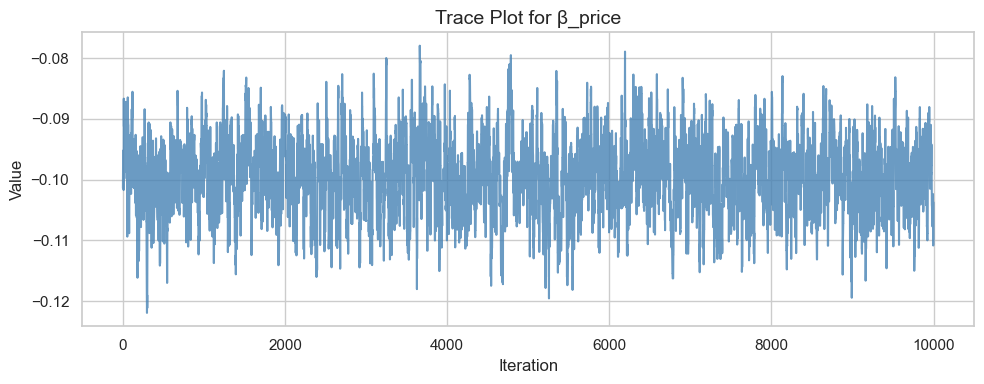

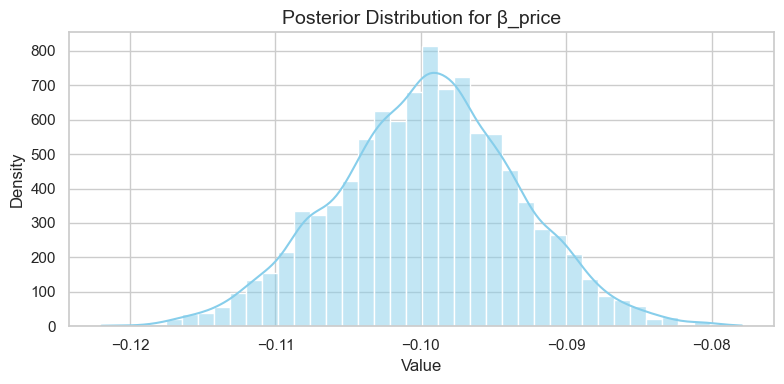

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

beta_price_samples = posterior_samples[:, 3]

sns.set(style="whitegrid", context="notebook")

# 🎨 Trace plot
plt.figure(figsize=(10, 4))
plt.plot(beta_price_samples, color="steelblue", alpha=0.8)
plt.title("Trace Plot for β_price", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.tight_layout()
plt.show()

# 🎨 Histogram + KDE
plt.figure(figsize=(8, 4))
sns.histplot(beta_price_samples, bins=40, kde=True, color="skyblue")
plt.title("Posterior Distribution for β_price", fontsize=14)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.tight_layout()
plt.show()